In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import imageio
import cv2
%matplotlib inline

将前9个视频与每帧的转向角度打包
其中视频每帧把图片的天空部分裁剪掉并转换成140\*140的大小

In [3]:

csv_files = glob.glob('epochs/*.csv')[:9]
mkv_files = glob.glob('epochs/*.mkv')[:9]
img_data=[[] for i in range(9)]
label_data=[[] for i in range(9)]

for index,(csv,mkv) in enumerate(zip(csv_files,mkv_files)):
    df = pd.read_csv(csv)
    label_data[index] = df['wheel'].values
    vid = imageio.get_reader(mkv, 'ffmpeg')
    for i in range(len(df)):
        img = cv2.resize(vid.get_data(i),(140,140))
        img_data[index].append(img)
    print('video {},'.format(index+1),'img_shape:',img_data[index][0].shape,'labels:',label_data[index].shape)

img_data = np.concatenate(img_data, axis=0)
label_data = np.concatenate(label_data, axis=0)
np.save('img_data',img_data) 
np.save('label_data',label_data)
print('END','img_shape:',img_data.shape ,'labels_shape:',label_data.shape)


video 1, img_shape: (140, 140, 3) labels: (1500,)
video 2, img_shape: (140, 140, 3) labels: (3900,)
video 3, img_shape: (140, 140, 3) labels: (2700,)
video 4, img_shape: (140, 140, 3) labels: (2700,)
video 5, img_shape: (140, 140, 3) labels: (2700,)
video 6, img_shape: (140, 140, 3) labels: (2700,)
video 7, img_shape: (140, 140, 3) labels: (2700,)
video 8, img_shape: (140, 140, 3) labels: (2700,)
video 9, img_shape: (140, 140, 3) labels: (2700,)
END img_shape: (24300, 140, 140, 3) labels_shape: (24300,)


In [143]:
img_data = np.load('img_data.npy')
label_data = np.load('label_data.npy')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012800FAB400>]],
      dtype=object)

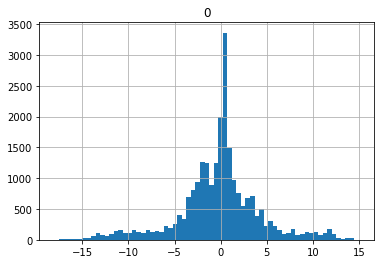

In [24]:
df= pd.DataFrame(label_data)
df.hist(bins=67)

In [37]:
pd.value_counts(abs(label_data)>1)

True     15305
False     8995
dtype: int64

In [30]:
pd.value_counts(label_data)

 0.5     3363
 0.0     2001
 1.0     1497
-2.0     1270
-0.5     1248
-1.5     1247
 1.5      973
-2.5      942
-1.0      886
-3.0      804
 2.0      764
 3.5      715
-3.5      694
 3.0      684
 2.5      545
 4.5      495
-4.5      403
 4.0      383
-4.0      334
 5.5      311
-5.0      252
-6.0      225
 6.0      221
 5.0      216
-5.5      187
 8.0      172
 12.0     170
-9.5      165
-11.0     154
 6.5      154
         ... 
-7.5      124
-10.0     113
-10.5     112
 10.0     108
 7.5      108
 11.5     108
-8.5      106
-13.5     104
 7.0      102
 9.0       96
 12.5      93
-12.0      91
 8.5       85
-13.0      85
 11.0      70
-12.5      66
-14.0      57
-15.0      35
 13.0      34
 14.5      32
 14.0      31
-14.5      26
 13.5      20
-15.5      14
-16.0      13
-16.5      12
-17.0      11
-17.5       7
-18.0       3
 15.0       3
Length: 67, dtype: int64

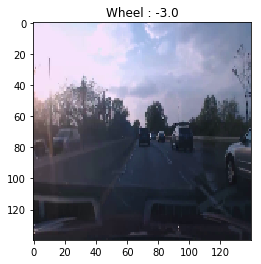

In [144]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
index = random.randint(0,len(img_data))
plt.title('Wheel : '+str(label_data[index]))
plt.imshow(img_data[index])

### 创建生成器

In [2]:
from sklearn.utils import shuffle
from math import fabs
import random
def add_shadow(img):                 #增加随机阴影
    h, w = img.shape[:2]
    [y1, y2] = np.random.choice(h, 2, replace=False)
    k = w / (y2 - y1) 
    b = - k * y1      
    img_shadow = img.copy()
    for i in range(w):
        c = int((i - b) / k)
        img_shadow[:c, i, :] = (img_shadow[:c, i, :] * .5) 
    return img_shadow

def Lower_brightness(orimg):        #增加变换色彩的图
    img = orimg.copy()
    img[:,:,0] = img[:,:,0]*random.uniform(0.5, 0.7)
    img[:,:,1] = img[:,:,1]*random.uniform(0.5, 0.7)
    img[:,:,2] = img[:,:,2]*random.uniform(0.5, 0.7)
    return img

def generator(data_path,label_path,batch_size=64):

    data = np.load(data_path)
    label = np.load(label_path)
    while 1:
        
        data,label = shuffle(data,label)
        images = []
        steers = []
        for orimg,steer in zip(data,label):

            images.append(orimg)
            steers.append(steer)
            #增加降低亮度的图
            
            images.append(Lower_brightness(orimg)) 
            steers.append(steer)

            if fabs(steer)> 1:
                
                #增加翻转图片
                img_flip = cv2.flip(orimg,1)
                images.append(img_flip)
                steers.append(steer*-1)

                #增加带随机阴影的图
                images.append(add_shadow(orimg))
                steers.append(steer)
            if len(images)>= batch_size :         
                X = np.array(images)   
                Y = np.array(steers)
                images = []
                steers = []
                yield (X,Y)

def valid_generator(batch_size=64):
    images = []
    steers = []
    vid = imageio.get_reader('epochs/epoch10_front.mkv', 'ffmpeg')
    df = pd.read_csv('epochs/epoch10_steering.csv') 
    for i,steer in zip(range(len(df)),df['wheel'].values):
            img = cv2.resize(vid.get_data(i),(140,140))
            images.append(img)
            steers.append(steer)
            if len(images)>= batch_size :         
                X = np.array(images)   
                Y = np.array(steers)
                images = []
                steers = []
                yield shuffle(X,Y)
        
           
            

In [9]:
vid = imageio.get_reader('epochs/epoch10_front.mkv', 'ffmpeg')
img = cv2.resize(vid.get_data(0),(140,140))
aaa=np.expand_dims(img,axis=0)
aaa.shape

(1, 140, 140, 3)

生成器一轮大约产生24300\*2+15305\*2=79210张图片

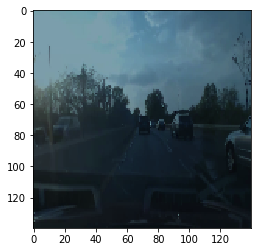

In [145]:
plt.imshow(Lower_brightness(img_data[index]))

In [146]:
a = next(generator('img_data.npy','label_data.npy'))
print(a[0].shape)
#plt.imshow(a[0][1])
print(a[1])

(66, 140, 140, 3)
[ 1.   1.  -0.5 -0.5  0.5  0.5 -7.  -7.   7.  -7.  -2.  -2.   2.  -2.
  0.5  0.5 -3.  -3.   3.  -3.  -2.5 -2.5  2.5 -2.5 -2.  -2.   2.  -2.
 -0.5 -0.5 -1.  -1.  -1.  -1.   0.5  0.5  6.   6.  -6.   6.   0.5  0.5
  3.   3.  -3.   3.   2.5  2.5 -2.5  2.5 -3.  -3.   3.  -3.   6.   6.
 -6.   6.   0.5  0.5  0.   0.  -2.5 -2.5  2.5 -2.5]


(67, 140, 140, 3)
[-13.5 -13.5  13.5 -13.5  -0.5  -0.5   1.    0.5  10.   10.  -10.   10.
   0.    1.    3.    3.   -3.    3.   -1.5  -1.5   1.5  -1.5 -10.  -10.
  10.  -10.    2.5   2.5  -2.5   2.5   2.5   2.5  -2.5   2.5   1.   -1.
   6.    6.   -6.    6.    0.5  13.   13.  -13.   13.    1.   -4.   -4.
   4.   -4.   -1.5  -1.5   1.5  -1.5   2.5   2.5  -2.5   2.5  -1.   -7.5
  -7.5   7.5  -7.5  -2.   -2.    2.   -2. ]
(64, 140, 140, 3)
[-1.  -1.   0.5 -3.  -3.   3.  -3.  -2.5 -2.5  2.5 -2.5 -8.  -8.   8.
 -8.   0.5  0.5  0.5 -2.5 -2.5  2.5 -2.5 -2.  -2.   2.  -2.   3.5  3.5
 -3.5  3.5  4.5  4.5 -4.5  4.5  2.5  2.5 -2.5  2.5  1.   1.5  1.5 -1.5
  1.5 -2.5 -2.5  2.5 -2.5  8.   8.  -8.   8.   1.   2.5  2.5 -2.5  2.5
 -3.5 -3.5  3.5 -3.5  5.5  5.5 -5.5  5.5]
(64, 140, 140, 3)
[  0.5   3.    3.   -3.    3.    0.5   3.    3.   -3.    3.   -2.   -2.
   2.   -2.    1.5   1.5  -1.5   1.5  -0.5   4.5   4.5  -4.5   4.5  -2.
  -2.    2.   -2.   -2.   -2.    2.   -2.   -1.5  -1.5   1.5  -1.5   0.5

(64, 140, 140, 3)
[  2.    2.   -2.    2.   -2.   -2.    2.   -2.   -4.   -4.    4.   -4.
   0.5   0.5   4.5   4.5  -4.5   4.5  -0.5  -3.5  -3.5   3.5  -3.5  -3.5
  -3.5   3.5  -3.5 -11.  -11.   11.  -11.    5.5   5.5  -5.5   5.5   5.5
   5.5  -5.5   5.5  -4.   -4.    4.   -4.   -0.5   0.5  11.5  11.5 -11.5
  11.5   1.   10.   10.  -10.   10.   -2.5  -2.5   2.5  -2.5   4.5   4.5
  -4.5   4.5   1.    0.5]
(66, 140, 140, 3)
[  0.5   0.5   2.    2.   -2.    2.   -5.5  -5.5   5.5  -5.5  -2.   -2.
   2.   -2.    0.   -0.5   0.5  10.   10.  -10.   10.    0.5 -12.  -12.
  12.  -12.    0.   13.   13.  -13.   13.    0.    3.5   3.5  -3.5   3.5
   0.5  -2.   -2.    2.   -2.   -1.   -8.   -8.    8.   -8.   -8.5  -8.5
   8.5  -8.5   1.5   1.5  -1.5   1.5   2.    2.   -2.    2.  -11.  -11.
  11.  -11.   -9.   -9.    9.   -9. ]
(65, 140, 140, 3)
[-1.5 -1.5  1.5 -1.5 -2.  -2.   2.  -2.   1.   5.5  5.5 -5.5  5.5 -4.5
 -4.5  4.5 -4.5 -4.  -4.   4.  -4.   3.5  3.5 -3.5  3.5  3.   3.  -3.
  3.  -3.5 -3.5

(67, 140, 140, 3)
[ 3.   3.  -3.   3.   1.  -0.5  0.5  1.  -1.5 -1.5  1.5 -1.5  3.   3.
 -3.   3.  -1.5 -1.5  1.5 -1.5 -2.  -2.   2.  -2.  -4.  -4.   4.  -4.
 -0.5 -6.5 -6.5  6.5 -6.5 -1.5 -1.5  1.5 -1.5 -1.   3.   3.  -3.   3.
 -2.5 -2.5  2.5 -2.5 -2.  -2.   2.  -2.   4.   4.  -4.   4.   0.  -3.
 -3.   3.  -3.  -1.5 -1.5  1.5 -1.5  2.5  2.5 -2.5  2.5]
(65, 140, 140, 3)
[  1.    1.   -3.5  -3.5   3.5  -3.5   1.5   1.5  -1.5   1.5   0.5  -2.5
  -2.5   2.5  -2.5  -3.   -3.    3.   -3.   -3.   -3.    3.   -3.   -3.
  -3.    3.   -3.   -7.5  -7.5   7.5  -7.5  13.5  13.5 -13.5  13.5  -2.
  -2.    2.   -2.   -3.5  -3.5   3.5  -3.5  -1.5  -1.5   1.5  -1.5   0.
   0.5   2.5   2.5  -2.5   2.5 -10.5 -10.5  10.5 -10.5  -3.   -3.    3.
  -3.   -8.   -8.    8.   -8. ]
(67, 140, 140, 3)
[  0.5   3.5   3.5  -3.5   3.5  -7.   -7.    7.   -7.   -2.5  -2.5   2.5
  -2.5  -7.5  -7.5   7.5  -7.5  -2.   -2.    2.   -2.    7.5   7.5  -7.5
   7.5  -3.   -3.    3.   -3.   10.5  10.5 -10.5  10.5  -2.5  -2.5   2

(65, 140, 140, 3)
[  0.5  -1.5  -1.5   1.5  -1.5   6.5   6.5  -6.5   6.5  -2.5  -2.5   2.5
  -2.5  -0.5  -6.   -6.    6.   -6.   -0.5   3.5   3.5  -3.5   3.5   1.5
   1.5  -1.5   1.5  -0.5   1.5   1.5  -1.5   1.5   0.5   0.5  -2.   -2.
   2.   -2.    4.5   4.5  -4.5   4.5   0.5   2.    2.   -2.    2.  -15.
 -15.   15.  -15.   -1.    0.5  -3.   -3.    3.   -3.   12.   12.  -12.
  12.   -1.5  -1.5   1.5  -1.5]
(66, 140, 140, 3)
[  0.   -1.5  -1.5   1.5  -1.5  -0.5   0.5  -4.   -4.    4.   -4.    0.5
   3.5   3.5  -3.5   3.5   0.   -3.   -3.    3.   -3.    2.    2.   -2.
   2.  -13.5 -13.5  13.5 -13.5   0.5   0.5  -2.   -2.    2.   -2.   -6.5
  -6.5   6.5  -6.5  -0.5   1.    0.5  -5.5  -5.5   5.5  -5.5   1.5   1.5
  -1.5   1.5   0.    0.5  -4.5  -4.5   4.5  -4.5   0.    0.    1.5   1.5
  -1.5   1.5   2.    2.   -2.    2. ]
(66, 140, 140, 3)
[  0.5  -1.5  -1.5   1.5  -1.5   6.5   6.5  -6.5   6.5   2.5   2.5  -2.5
   2.5   4.    4.   -4.    4.   -8.   -8.    8.   -8.  -13.  -13.   13.
 -13.

(65, 140, 140, 3)
[ -5.   -5.    5.   -5.   -3.5  -3.5   3.5  -3.5   1.5   1.5  -1.5   1.5
  -1.   -7.5  -7.5   7.5  -7.5   1.5   1.5  -1.5   1.5  11.5  11.5 -11.5
  11.5   0.  -11.  -11.   11.  -11.   -8.   -8.    8.   -8.   -2.   -2.
   2.   -2.    1.   -4.   -4.    4.   -4.    0.5   4.5   4.5  -4.5   4.5
   0.5  11.   11.  -11.   11.    1.5   1.5  -1.5   1.5  -2.   -2.    2.
  -2.    4.    4.   -4.    4. ]
(67, 140, 140, 3)
[  1.5   1.5  -1.5   1.5   1.   -1.   -3.5  -3.5   3.5  -3.5   0.    1.
   0.5  -2.   -2.    2.   -2.   -3.   -3.    3.   -3.    1.5   1.5  -1.5
   1.5   2.    2.   -2.    2.    0.    0.   -2.   -2.    2.   -2.    0.5
   1.5   1.5  -1.5   1.5  13.   13.  -13.   13.   -1.5  -1.5   1.5  -1.5
   1.    0.   -5.   -5.    5.   -5.    0.5  -4.   -4.    4.   -4.   -2.
  -2.    2.   -2.    2.5   2.5  -2.5   2.5]
(64, 140, 140, 3)
[ -0.5   1.5   1.5  -1.5   1.5   8.    8.   -8.    8.   -9.   -9.    9.
  -9.    0.    1.   -6.   -6.    6.   -6.   -2.   -2.    2.   -2.    5.5

(66, 140, 140, 3)
[ -1.    0.5   4.    4.   -4.    4.   -2.   -2.    2.   -2.   -2.   -2.
   2.   -2.   -0.5  -7.5  -7.5   7.5  -7.5  -2.5  -2.5   2.5  -2.5   0.
  -3.   -3.    3.   -3.    4.5   4.5  -4.5   4.5 -14.  -14.   14.  -14.
  -0.5  -1.   -1.5  -1.5   1.5  -1.5   0.5   9.5   9.5  -9.5   9.5   0.
 -10.  -10.   10.  -10.    1.    8.    8.   -8.    8.    1.    4.    4.
  -4.    4.   -2.   -2.    2.   -2. ]
(64, 140, 140, 3)
[  9.    9.   -9.    9.    6.    6.   -6.    6.   -5.5  -5.5   5.5  -5.5
   2.5   2.5  -2.5   2.5   1.5   1.5  -1.5   1.5 -13.5 -13.5  13.5 -13.5
   0.5 -12.  -12.   12.  -12.    0.   -1.  -15.  -15.   15.  -15.    2.5
   2.5  -2.5   2.5  11.   11.  -11.   11.    8.    8.   -8.    8.  -11.5
 -11.5  11.5 -11.5  -1.5  -1.5   1.5  -1.5   2.    2.   -2.    2.   -1.5
  -1.5   1.5  -1.5   0. ]
(64, 140, 140, 3)
[  0.5   0.   -2.   -2.    2.   -2.   -1.    5.5   5.5  -5.5   5.5 -15.5
 -15.5  15.5 -15.5   7.5   7.5  -7.5   7.5   1.   -4.   -4.    4.   -4.
  -2.5  -2.5

(66, 140, 140, 3)
[ -4.5  -4.5   4.5  -4.5   4.5   4.5  -4.5   4.5   1.    1.    2.    2.
  -2.    2.   -0.5   2.5   2.5  -2.5   2.5   0.    9.5   9.5  -9.5   9.5
  -1.5  -1.5   1.5  -1.5  -3.5  -3.5   3.5  -3.5   0.5  -9.5  -9.5   9.5
  -9.5  -1.    2.    2.   -2.    2.   -1.    2.5   2.5  -2.5   2.5  -2.
  -2.    2.   -2.    3.    3.   -3.    3.    0.5   8.    8.   -8.    8.
   0.5   0.5  10.5  10.5 -10.5  10.5]
(65, 140, 140, 3)
[ -3.5  -3.5   3.5  -3.5  -2.   -2.    2.   -2.    0.5   0.5  -1.5  -1.5
   1.5  -1.5   3.    3.   -3.    3.   -2.   -2.    2.   -2.    1.    3.
   3.   -3.    3.   -5.5  -5.5   5.5  -5.5   0.5   0.5   1.    1.    1.
  12.5  12.5 -12.5  12.5   0.5   3.    3.   -3.    3.   -1.5  -1.5   1.5
  -1.5   0.5  -2.   -2.    2.   -2.   -1.   -2.5  -2.5   2.5  -2.5   0.5
   0.5   3.5   3.5  -3.5   3.5]
(64, 140, 140, 3)
[ 4.5  4.5 -4.5  4.5  0.5 -0.5  0.5  1.   4.5  4.5 -4.5  4.5  0.5  2.5
  2.5 -2.5  2.5 -8.  -8.   8.  -8.   0.5  2.   2.  -2.   2.  -7.5 -7.5
  7.5 -7.

(65, 140, 140, 3)
[ -5.5  -5.5   5.5  -5.5 -10.  -10.   10.  -10.    0.5   0.    1.5   1.5
  -1.5   1.5  -1.  -16.  -16.   16.  -16.    0.5   5.5   5.5  -5.5   5.5
   1.    5.    5.   -5.    5.    1.5   1.5  -1.5   1.5   0.5  -0.5  -2.
  -2.    2.   -2.    0.5   0.5   0.   -5.   -5.    5.   -5.    0.5   2.
   2.   -2.    2.    8.    8.   -8.    8.    0.   13.5  13.5 -13.5  13.5
   0.5   7.    7.   -7.    7. ]
(65, 140, 140, 3)
[  0.5   4.    4.   -4.    4.    4.    4.   -4.    4.   -1.    3.5   3.5
  -3.5   3.5   0.5  -2.   -2.    2.   -2.  -13.  -13.   13.  -13.    5.
   5.   -5.    5.   -1.   -4.5  -4.5   4.5  -4.5  -2.5  -2.5   2.5  -2.5
   8.    8.   -8.    8.   -0.5  -1.5  -1.5   1.5  -1.5   3.5   3.5  -3.5
   3.5 -17.  -17.   17.  -17.    3.5   3.5  -3.5   3.5   1.5   1.5  -1.5
   1.5  12.   12.  -12.   12. ]
(67, 140, 140, 3)
[  2.5   2.5  -2.5   2.5 -11.5 -11.5  11.5 -11.5   2.5   2.5  -2.5   2.5
   3.    3.   -3.    3.   -5.5  -5.5   5.5  -5.5  -0.5   0.   -0.5   0.
   0.5 -10

(67, 140, 140, 3)
[  0.    2.5   2.5  -2.5   2.5  10.   10.  -10.   10.   -4.5  -4.5   4.5
  -4.5   0.5  -6.   -6.    6.   -6.   -2.5  -2.5   2.5  -2.5  -0.5   0.5
   0.5   2.    2.   -2.    2.    6.    6.   -6.    6.    0.    7.5   7.5
  -7.5   7.5  -2.   -2.    2.   -2.    0.5   4.5   4.5  -4.5   4.5   0.5
   1.   -1.   -1.5  -1.5   1.5  -1.5   0.5   4.    4.   -4.    4.   -6.5
  -6.5   6.5  -6.5   4.    4.   -4.    4. ]
(64, 140, 140, 3)
[ 0.   1.  -8.5 -8.5  8.5 -8.5 -4.5 -4.5  4.5 -4.5  0.   1.5  1.5 -1.5
  1.5 -2.  -2.   2.  -2.   0.5 -1.  -3.5 -3.5  3.5 -3.5  0.5  3.5  3.5
 -3.5  3.5 -1.5 -1.5  1.5 -1.5  1.   0.  -2.  -2.   2.  -2.  -0.5 -4.
 -4.   4.  -4.  -2.  -2.   2.  -2.   0.   0.5 -2.  -2.   2.  -2.  -1.5
 -1.5  1.5 -1.5 -0.5 -2.5 -2.5  2.5 -2.5]
(64, 140, 140, 3)
[ -6.   -6.    6.   -6.    0.    0.5  -0.5  -0.5  -4.   -4.    4.   -4.
  -3.5  -3.5   3.5  -3.5  -2.5  -2.5   2.5  -2.5   1.   -5.   -5.    5.
  -5.   -4.5  -4.5   4.5  -4.5  10.5  10.5 -10.5  10.5  -2.5  -2.5  

(67, 140, 140, 3)
[ -4.   -4.    4.   -4.    1.    1.    0.5   2.    2.   -2.    2.    6.
   6.   -6.    6.   -1.    0.5   0.   -2.5  -2.5   2.5  -2.5  -1.5  -1.5
   1.5  -1.5  -0.5   0.   -2.   -2.    2.   -2.   -1.5  -1.5   1.5  -1.5
  -8.5  -8.5   8.5  -8.5  -1.5  -1.5   1.5  -1.5   2.5   2.5  -2.5   2.5
  -1.    0.5  -6.   -6.    6.   -6.   -1.5  -1.5   1.5  -1.5   0.   -8.
  -8.    8.   -8.  -12.5 -12.5  12.5 -12.5]
(65, 140, 140, 3)
[ -2.   -2.    2.   -2.  -13.  -13.   13.  -13.    8.5   8.5  -8.5   8.5
 -10.5 -10.5  10.5 -10.5   1.    1.5   1.5  -1.5   1.5   0.5   0.    0.
  -1.5  -1.5   1.5  -1.5   0.   -0.5  -4.5  -4.5   4.5  -4.5  -7.   -7.
   7.   -7.   -1.5  -1.5   1.5  -1.5   1.5   1.5  -1.5   1.5   1.    0.5
   1.5   1.5  -1.5   1.5   3.    3.   -3.    3.    0.    3.5   3.5  -3.5
   3.5  -1.5  -1.5   1.5  -1.5]
(66, 140, 140, 3)
[ 11.5  11.5 -11.5  11.5   3.    3.   -3.    3.   -1.5  -1.5   1.5  -1.5
   9.5   9.5  -9.5   9.5   4.    4.   -4.    4.    4.5   4.5  -4.5   4.

(67, 140, 140, 3)
[ -1.    2.5   2.5  -2.5   2.5   1.   -3.   -3.    3.   -3.    0.5   8.
   8.   -8.    8.   -3.5  -3.5   3.5  -3.5  -4.5  -4.5   4.5  -4.5  -8.
  -8.    8.   -8.   -4.5  -4.5   4.5  -4.5   0.5  -3.5  -3.5   3.5  -3.5
  -7.5  -7.5   7.5  -7.5   1.    0.   10.   10.  -10.   10.    1.   -5.
  -5.    5.   -5.  -10.5 -10.5  10.5 -10.5  10.5  10.5 -10.5  10.5  -8.5
  -8.5   8.5  -8.5   6.5   6.5  -6.5   6.5]
(64, 140, 140, 3)
[ -9.5  -9.5   9.5  -9.5   0.    0.5   9.    9.   -9.    9.   -3.   -3.
   3.   -3.   -2.   -2.    2.   -2.    0.5   4.5   4.5  -4.5   4.5   0.
  -2.5  -2.5   2.5  -2.5  -4.5  -4.5   4.5  -4.5  -1.5  -1.5   1.5  -1.5
  -3.   -3.    3.   -3.  -11.  -11.   11.  -11.   -6.5  -6.5   6.5  -6.5
  -0.5   0.5   0.5   3.5   3.5  -3.5   3.5  10.   10.  -10.   10.    2.
   2.   -2.    2.    0.5]
(64, 140, 140, 3)
[  5.5   5.5  -5.5   5.5   3.    3.   -3.    3.    5.    5.   -5.    5.
   1.5   1.5  -1.5   1.5  -3.   -3.    3.   -3.   12.5  12.5 -12.5  12.5
   0.  

(64, 140, 140, 3)
[  3.    3.   -3.    3.    1.5   1.5  -1.5   1.5  -0.5   0.5 -10.5 -10.5
  10.5 -10.5   9.    9.   -9.    9.   -3.   -3.    3.   -3.    0.5   1.
  -7.   -7.    7.   -7.    0.   -0.5   0.5   0.   -2.   -2.    2.   -2.
  -9.5  -9.5   9.5  -9.5   8.    8.   -8.    8.    0.    0.5  -5.5  -5.5
   5.5  -5.5  -2.   -2.    2.   -2.    1.    1.5   1.5  -1.5   1.5   3.
   3.   -3.    3.    0.5]
(64, 140, 140, 3)
[ 9.   9.  -9.   9.   2.5  2.5 -2.5  2.5 -3.5 -3.5  3.5 -3.5  0.   0.5
  1.   4.5  4.5 -4.5  4.5  0.5  0.5 -2.5 -2.5  2.5 -2.5 -2.  -2.   2.
 -2.  -0.5  0.5 -6.  -6.   6.  -6.   0.5 -5.5 -5.5  5.5 -5.5 -1.5 -1.5
  1.5 -1.5  0.   0.5 -5.  -5.   5.  -5.   2.   2.  -2.   2.   0.5  1.5
  1.5 -1.5  1.5  0.  -4.5 -4.5  4.5 -4.5]
(64, 140, 140, 3)
[  0.    5.    5.   -5.    5.    5.    5.   -5.    5.   -1.    1.5   1.5
  -1.5   1.5   0.  -14.  -14.   14.  -14.   -2.   -2.    2.   -2.    6.5
   6.5  -6.5   6.5  -2.   -2.    2.   -2.   -0.5  -6.   -6.    6.   -6.
 -12.5 -12.5  1

(66, 140, 140, 3)
[  1.5   1.5  -1.5   1.5  -5.5  -5.5   5.5  -5.5   1.    0.   -3.   -3.
   3.   -3.    1.    2.5   2.5  -2.5   2.5  -6.   -6.    6.   -6.    4.5
   4.5  -4.5   4.5  -3.5  -3.5   3.5  -3.5   0.    1.   11.   11.  -11.
  11.    3.5   3.5  -3.5   3.5   0.5   6.5   6.5  -6.5   6.5  10.5  10.5
 -10.5  10.5   1.    0.5   0.5  10.5  10.5 -10.5  10.5   1.   -4.5  -4.5
   4.5  -4.5  -3.   -3.    3.   -3. ]
(67, 140, 140, 3)
[  0.   10.5  10.5 -10.5  10.5  -3.   -3.    3.   -3.    1.    1.   -5.5
  -5.5   5.5  -5.5  -3.   -3.    3.   -3.    0.5   0.   -5.5  -5.5   5.5
  -5.5  -3.   -3.    3.   -3.    4.5   4.5  -4.5   4.5  -0.5  -3.5  -3.5
   3.5  -3.5   2.    2.   -2.    2.   -7.   -7.    7.   -7.    0.5   0.
   0.   14.5  14.5 -14.5  14.5  -3.5  -3.5   3.5  -3.5   0.   -2.   -2.
   2.   -2.    0.5   3.5   3.5  -3.5   3.5]
(66, 140, 140, 3)
[  0.5   1.    0.   -0.5   2.    2.   -2.    2.    6.    6.   -6.    6.
  -0.5   7.    7.   -7.    7.    0.5  -1.5  -1.5   1.5  -1.5   2.5

(66, 140, 140, 3)
[  0.5   9.    9.   -9.    9.    0.5  -2.   -2.    2.   -2.    0.5 -10.
 -10.   10.  -10.   -3.5  -3.5   3.5  -3.5   1.5   1.5  -1.5   1.5   0.
   5.5   5.5  -5.5   5.5   0.    0.   -4.5  -4.5   4.5  -4.5  -3.5  -3.5
   3.5  -3.5   0.5  -1.    0.    0.5   0.   -0.5  -0.5   3.    3.   -3.
   3.    3.5   3.5  -3.5   3.5   5.5   5.5  -5.5   5.5   0.5  12.   12.
 -12.   12.    2.5   2.5  -2.5   2.5]
(66, 140, 140, 3)
[ -2.   -2.    2.   -2.   -7.   -7.    7.   -7.    0.5   1.    0.5   1.5
   1.5  -1.5   1.5   1.   -2.   -2.    2.   -2.   -1.5  -1.5   1.5  -1.5
  -4.5  -4.5   4.5  -4.5  -1.    5.5   5.5  -5.5   5.5  -0.5  -2.   -2.
   2.   -2.    0.    0.5   0.5  -4.5  -4.5   4.5  -4.5   5.5   5.5  -5.5
   5.5   0.5 -10.5 -10.5  10.5 -10.5  -7.   -7.    7.   -7.  -10.  -10.
  10.  -10.   -4.5  -4.5   4.5  -4.5]
(67, 140, 140, 3)
[ -0.5   3.    3.   -3.    3.   -2.5  -2.5   2.5  -2.5 -14.  -14.   14.
 -14.   -9.5  -9.5   9.5  -9.5   2.5   2.5  -2.5   2.5   0.   -2.5  -2.5
 

(64, 140, 140, 3)
[  5.5   5.5  -5.5   5.5   2.5   2.5  -2.5   2.5  -5.   -5.    5.   -5.
  -1.5  -1.5   1.5  -1.5   0.    4.5   4.5  -4.5   4.5   0.5  -1.5  -1.5
   1.5  -1.5  -2.   -2.    2.   -2.    1.5   1.5  -1.5   1.5   0.   -2.
  -2.    2.   -2.   -3.   -3.    3.   -3.    6.5   6.5  -6.5   6.5  -2.5
  -2.5   2.5  -2.5  14.5  14.5 -14.5  14.5   7.    7.   -7.    7.    0.5
  -7.5  -7.5   7.5  -7.5]
(64, 140, 140, 3)
[ 1.5  1.5 -1.5  1.5  2.5  2.5 -2.5  2.5  2.   2.  -2.   2.  -3.5 -3.5
  3.5 -3.5  3.   3.  -3.   3.   0.  -3.  -3.   3.  -3.   4.5  4.5 -4.5
  4.5  2.   2.  -2.   2.  -3.5 -3.5  3.5 -3.5  0.5  0.5  8.5  8.5 -8.5
  8.5  1.5  1.5 -1.5  1.5  0.  -8.  -8.   8.  -8.  -9.5 -9.5  9.5 -9.5
 -2.  -2.   2.  -2.  -2.  -2.   2.  -2. ]
(64, 140, 140, 3)
[  0.5 -10.  -10.   10.  -10.    2.    2.   -2.    2.    3.5   3.5  -3.5
   3.5  -4.5  -4.5   4.5  -4.5  -1.    1.    4.5   4.5  -4.5   4.5  -1.5
  -1.5   1.5  -1.5  -2.5  -2.5   2.5  -2.5   1.   -5.   -5.    5.   -5.
  -1.   -2.  

(64, 140, 140, 3)
[  3.5   3.5  -3.5   3.5  -0.5  -3.   -3.    3.   -3.    0.5  -1.    0.5
   1.    0.5  -1.   -5.5  -5.5   5.5  -5.5 -11.  -11.   11.  -11.   -0.5
  -1.    3.5   3.5  -3.5   3.5   4.5   4.5  -4.5   4.5   1.5   1.5  -1.5
   1.5   0.    1.5   1.5  -1.5   1.5   1.    2.    2.   -2.    2.   -0.5
   1.    0.5   8.    8.   -8.    8.    3.    3.   -3.    3.    1.   -2.
  -2.    2.   -2.    0.5]
(65, 140, 140, 3)
[ -4.   -4.    4.   -4.    8.    8.   -8.    8.    1.5   1.5  -1.5   1.5
  -3.   -3.    3.   -3.    0.    2.5   2.5  -2.5   2.5   1.   -3.   -3.
   3.   -3.    0.5  -2.5  -2.5   2.5  -2.5  -6.   -6.    6.   -6.    0.5
   0.   12.5  12.5 -12.5  12.5  -1.   -5.   -5.    5.   -5.    0.5   9.5
   9.5  -9.5   9.5  -1.    0.5  -5.5  -5.5   5.5  -5.5  -1.5  -1.5   1.5
  -1.5 -13.  -13.   13.  -13. ]
(66, 140, 140, 3)
[ 1.   0.   0.5  1.5  1.5 -1.5  1.5 -2.  -2.   2.  -2.  -4.5 -4.5  4.5
 -4.5 -7.5 -7.5  7.5 -7.5 -1.   0.  -3.5 -3.5  3.5 -3.5 -1.  -3.  -3.
  3.  -3.  -2.5 -2.

(67, 140, 140, 3)
[  6.5   6.5  -6.5   6.5  -3.   -3.    3.   -3.    0.    1.5   1.5  -1.5
   1.5   0.   -2.5  -2.5   2.5  -2.5  -0.5  -5.5  -5.5   5.5  -5.5  -7.
  -7.    7.   -7.    4.    4.   -4.    4.   12.5  12.5 -12.5  12.5   1.5
   1.5  -1.5   1.5   0.5  10.   10.  -10.   10.    2.5   2.5  -2.5   2.5
   3.    3.   -3.    3.    0.5   0.    4.    4.   -4.    4.    8.    8.
  -8.    8.    0.    4.5   4.5  -4.5   4.5]
(66, 140, 140, 3)
[ -6.   -6.    6.   -6.    8.5   8.5  -8.5   8.5  -9.5  -9.5   9.5  -9.5
  -3.   -3.    3.   -3.    0.5  -3.5  -3.5   3.5  -3.5   0.    0.5  -0.5
   4.5   4.5  -4.5   4.5   3.    3.   -3.    3.    1.5   1.5  -1.5   1.5
  -7.5  -7.5   7.5  -7.5   2.    2.   -2.    2.   -5.   -5.    5.   -5.
   3.5   3.5  -3.5   3.5   8.5   8.5  -8.5   8.5  -0.5  -5.5  -5.5   5.5
  -5.5   0.5  10.5  10.5 -10.5  10.5]
(64, 140, 140, 3)
[ -0.5  -1.  -11.5 -11.5  11.5 -11.5   0.5  14.5  14.5 -14.5  14.5   3.
   3.   -3.    3.   -2.5  -2.5   2.5  -2.5   0.   -0.5   5.5   5.

KeyboardInterrupt: 

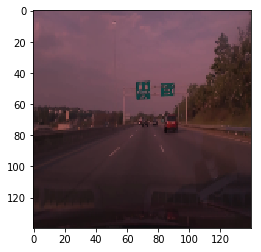

In [3]:
for i in generator('img_data.npy','label_data.npy'):
    print(i[0].shape)
    plt.imshow(i[0][1])
    print(i[1])

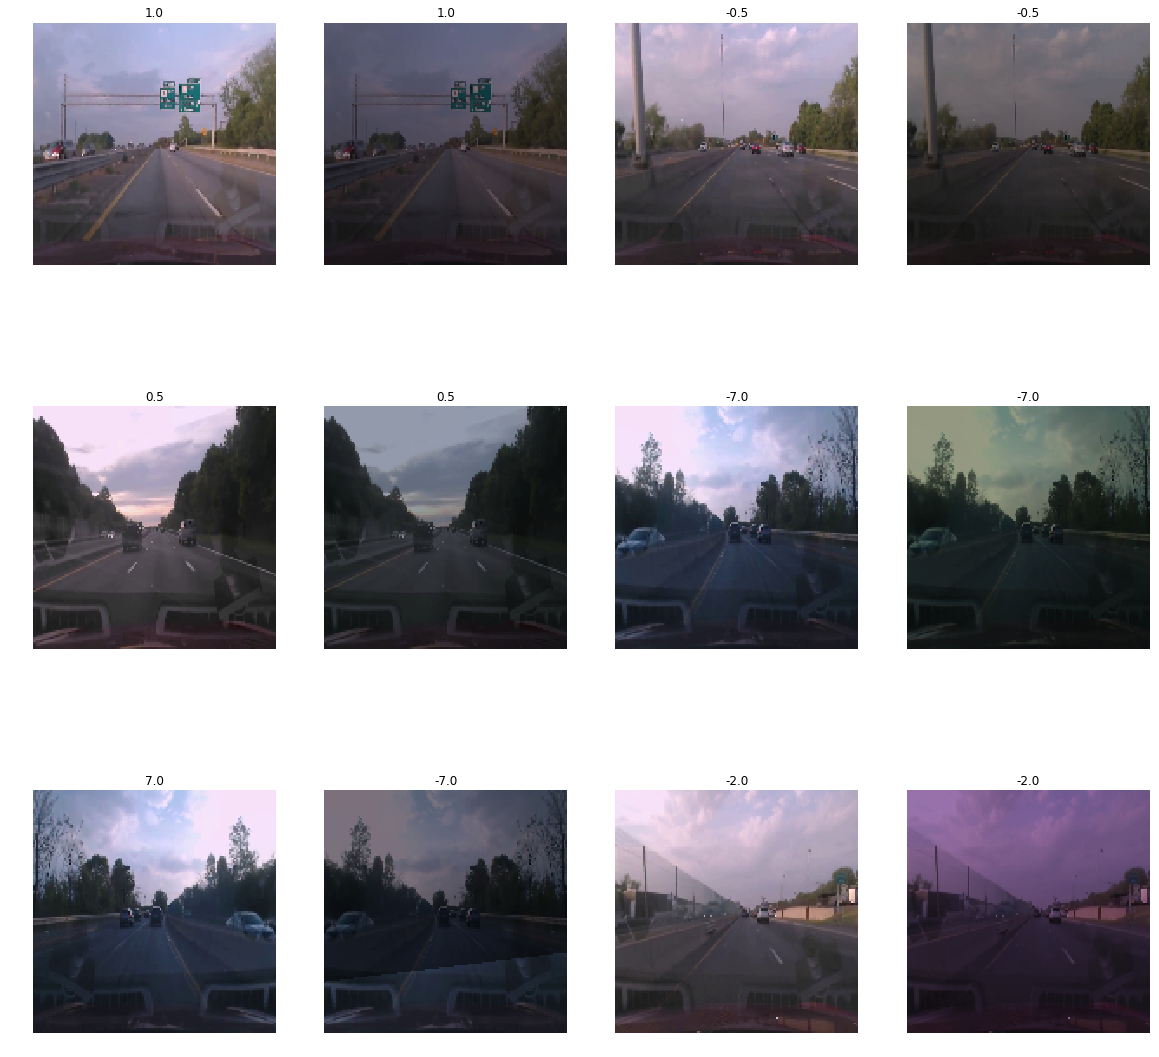

In [156]:
plt.figure(figsize=(20, 20))
for (i, p),s in zip(enumerate(a[0][:12]),a[1][:12]):
    plt.subplot(3, 4, i+1)
    plt.imshow(p)
    plt.title(s)
    plt.axis('off')
plt.show()

In [4]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense, Activation,Conv2D,Flatten,Lambda,GlobalAveragePooling2D,Dropout
base_model = InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(140,140,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1)(x)
model = Model(inputs=base_model.input,outputs=output)

for layer in base_model.layers[:-12]:
    layer.trainable = False    
    
model.compile(optimizer='Adadelta', loss="mse")


F:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 140, 140, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1016 (Conv2D)            (None, 69, 69, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1016 (Batch (None, 69, 69, 32)   96          conv2d_1016[0][0]                
__________________________________________________________________________________________________
activation_1016 (Activation)    (None, 69, 69, 32)   0           batch_normalization_1016[0][0]   
__________________________________________________________________________________________________
conv2d_101

conv2d_1201 (Conv2D)            (None, 3, 3, 224)    129024      activation_1200[0][0]            
__________________________________________________________________________________________________
batch_normalization_1201 (Batch (None, 3, 3, 224)    672         conv2d_1201[0][0]                
__________________________________________________________________________________________________
activation_1201 (Activation)    (None, 3, 3, 224)    0           batch_normalization_1201[0][0]   
__________________________________________________________________________________________________
conv2d_1199 (Conv2D)            (None, 3, 3, 192)    399360      block8_5_ac[0][0]                
__________________________________________________________________________________________________
conv2d_1202 (Conv2D)            (None, 3, 3, 256)    172032      activation_1201[0][0]            
__________________________________________________________________________________________________
batch_norm

In [139]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
callback = LossHistory()    

history=model.fit_generator(generator('img_data.npy','label_data.npy',batch_size=64),steps_per_epoch=1200,epochs=5,callbacks=[callback])

Epoch 1/5
1200/1200 [==============================] - 446s 372ms/step - loss: 1.0447
Epoch 2/5
1200/1200 [==============================] - 454s 378ms/step - loss: 1.0077
Epoch 3/5
1200/1200 [==============================] - 454s 378ms/step - loss: 0.9632
Epoch 4/5
1200/1200 [==============================] - 453s 377ms/step - loss: 0.9611
Epoch 5/5
1200/1200 [==============================] - 454s 378ms/step - loss: 0.9147


In [140]:
model.save('./models/model.h5')
with open('./models/model.json', 'w') as f:
    f.write(model.to_json())

In [141]:
oldhistory =np.load('model_loss.npy')
model_loss = list(oldhistory)
model_loss.extend(history.history["loss"])
np.save('model_loss',model_loss)

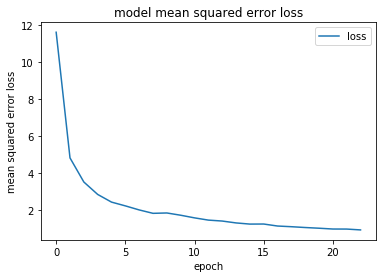

In [142]:
plt.plot(model_loss)
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['loss'])
plt.show()

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Conv2D,Flatten,Lambda
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
input_shape = (140,140,3)
model = Sequential()
model.add(Lambda(lambda x:x/255 - 0.5, input_shape=input_shape))
model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2), padding="valid"))
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2), padding="valid"))
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2), padding="valid"))
model.add(Conv2D(64, (3, 3), activation="relu", strides=(1, 1), padding="valid"))
model.add(Conv2D(64, (3, 3), activation="relu", strides=(1, 1), padding="valid"))
model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='tanh'))
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss="mse")

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 140, 140, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 68, 68, 24)        1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 48)        43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 64)        27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 6400)              0         
__________

In [11]:
history_basemodel=model.fit_generator(generator('img_data.npy','label_data.npy',batch_size=64),steps_per_epoch=1200,epochs=5)

Epoch 1/5
1200/1200 [==============================] - 95s 79ms/step - loss: 22.6109
Epoch 2/5
1200/1200 [==============================] - 92s 77ms/step - loss: 20.2955
Epoch 3/5
1200/1200 [==============================] - 91s 76ms/step - loss: 19.8348
Epoch 4/5
1200/1200 [==============================] - 91s 76ms/step - loss: 19.6453
Epoch 5/5
1200/1200 [==============================] - 90s 75ms/step - loss: 19.7573


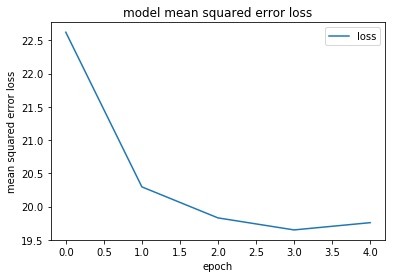

In [12]:
plt.plot(history_basemodel.history["loss"])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['loss'])
plt.show()